# **<span style="color:green;font-size:40px;">Coronavirus Tweet Sentiment Analysis</span>**


# **<span style="color:blue;"> Import Necessary Libraries</span>**


In [28]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [30]:
import os
datadir = "/content/drive/MyDrive/SMA/"
if not os.path.exists(datadir):
  !ln -s "" $datadir
os.chdir(datadir)
!pwd

/content/drive/MyDrive/SMA


In [31]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re # for regular expressions
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import string
import nltk # for text manipulation
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
#from gensim.models.doc2vec import LabeledSentence
import gensim
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# **<span style="color:blue;"> Load the Dataset</span>**


In [36]:
df = pd.read_csv(
    "./archive/Covid-19 Twitter Dataset (Apr-Jun 2021).csv", encoding="latin-1"
)

In [43]:
# List of file paths for the other datasets
file_paths = [
    "./archive/Covid-19 Twitter Dataset (Aug-Sep 2020).csv",
    "./archive/Covid-19 Twitter Dataset (Apr-Jun 2020).csv"
    # Add more file paths as needed
]

# Read and concatenate the other datasets
for file_path in file_paths:
    temp_df = pd.read_csv(file_path, encoding="latin-1")
    df = pd.concat([df, temp_df], ignore_index=True)

In [44]:
df.head()

id  created_at  \
0  1.386694e+18  2021-04-26   
1  1.386694e+18  2021-04-26   
2  1.386694e+18  2021-04-26   
3  1.386694e+18  2021-04-26   
4  1.386694e+18  2021-04-26   

                                                                                 source  \
0  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   
1    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
2    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
3               <a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>   
4               <a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>   

                                                                                                                                        original_text  \
0      RT @VP: The U.S. is working closely with the Indian government to rapidly deploy additional support and supplies during an alarming COVID-1â¦   
1                                             RT @JackPosobiec: Flip-Flop Fauci admits outdoor COVID transmission is very low https://t.co/6ztO7pOH1i   
2  RT @timmy315: Hi Twitter, Iâm Tim Manning, the White House COVID-19 Supply Coordinator. Thereâs been a lot of confusion around the use of tâ¦   
3       RT @itsaadee: Praying for #India as the country battles the worst #Covid-19 surge the world has witnessed. Let's all - irrespective of theâ¦   
4                                                      Rapid Investment in Nursing to Strengthen the Global COVID-19 Response https://t.co/z0mDQDGgTu   

  lang  favorite_count  retweet_count  original_author      hashtags  \
0   en             0.0            0.0  jfd4humanrights           NaN   
1   en             0.0            0.0      andgrateful           NaN   
2   en             0.0          252.0       jlreader8B           NaN   
3   en             0.0            2.0    ijennychauhan  India, Covid   
4   en             0.0         7937.0      IJNSJournal           NaN   

  user_mentions    place  \
0            VP  Alabama   
1  JackPosobiec      NaN   
2      timmy315      NaN   
3      itsaadee      NaN   
4           NaN       UK   

                                                                   clean_tweet  \
0   work close indian govern rapidli deploy addit support suppli alarm covid19   
1                          flip flop fauci admit outdoor covid19 transmiss low   
2   hi twitter tim man white hous covid19 suppli coordin lot confus around use   
3                        pray countri battl worst surg world wit let irrespect   
4                          rapid invest nurs strengthen global covid19 respons   

   compound    neg    neu    pos sentiment  
0    0.0772  0.170  0.638  0.191       pos  
1   -0.4019  0.398  0.442  0.159       neg  
2    0.0000  0.000  1.000  0.000       neu  
3   -0.4215  0.306  0.522  0.172       neg  
4    0.3182  0.000  0.723  0.277       pos

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411887 entries, 0 to 411886
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               411883 non-null  float64
 1   created_at       411885 non-null  object 
 2   source           411587 non-null  object 
 3   original_text    411885 non-null  object 
 4   lang             411884 non-null  object 
 5   favorite_count   411884 non-null  float64
 6   retweet_count    411884 non-null  float64
 7   original_author  411884 non-null  object 
 8   hashtags         97775 non-null   object 
 9   user_mentions    295207 non-null  object 
 10  place            293775 non-null  object 
 11  clean_tweet      409915 non-null  object 
 12  compound         411887 non-null  float64
 13  neg              411887 non-null  float64
 14  neu              411887 non-null  float64
 15  pos              411887 non-null  float64
 16  sentiment        411887 non-null  obje

In [46]:
df.shape

(411887, 17)

In [47]:
# Names Of columns in our dataset
df.columns

Index(['id', 'created_at', 'source', 'original_text', 'lang', 'favorite_count',
       'retweet_count', 'original_author', 'hashtags', 'user_mentions',
       'place', 'clean_tweet', 'compound', 'neg', 'neu', 'pos', 'sentiment'],
      dtype='object')

In [48]:
# All tweets came only from April, May and June months of 2020.
df.created_at.value_counts()

created_at
2021-06-03    7229
2020-05-04    7165
2021-05-25    7114
2020-09-27    7040
2020-09-30    7028
              ... 
2021-05-20     352
2020-04-19     339
2021-04-27     220
2020-06-08     209
2020-04-23     163
Name: count, Length: 154, dtype: int64

In [49]:
# There are 35495 unique locations from where the tweets came.
df["place"].value_counts()

place
United States                 4539
India                         4283
London                        2646
London, England               2638
Washington, DC                2351
                              ... 
Gorleston                        1
Sharpsburg, MD                   1
Bondi NSW Australia              1
#Bharat@Rajasthan-Bhilwara       1
AT THE MOVIES                    1
Name: count, Length: 76294, dtype: int64

In [50]:
# There are 3 unique sentiment types in our dataset
df["sentiment"].value_counts()

sentiment
neu    174898
pos    127360
neg    109629
Name: count, dtype: int64

## **<span style="color:blue;">Going deeper into tweet and sentiment.</span>**


In [51]:
df[df["sentiment"] == "pos"].head()

id  created_at  \
0   1.386694e+18  2021-04-26   
4   1.386694e+18  2021-04-26   
7   1.386694e+18  2021-04-26   
12  1.386694e+18  2021-04-26   
18  1.386694e+18  2021-04-26   

                                                                                  source  \
0   <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   
4                <a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>   
7                <a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>   
12    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
18    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                                       original_text  \
0     RT @VP: The U.S. is working closely with the Indian government to rapidly deploy additional support and supplies during an alarming COVID-1â¦   
4                                                     Rapid Investment in Nursing to Strengthen the Global COVID-19 Response https://t.co/z0mDQDGgTu   
7                COVID-19: Legal action launched after Italian woman dies weeks after hav... https://t.co/hXt7Yw34OF via @YouTube #covid19 #vaccines   
12  RT @mochidobby: Official statement from Apgujeong High School\n\n[Urgent] This is an information on the outbreak of confirmed cases of Covid-â¦   
18  RT @ONeducation: Attention parents!\n\nIf you received a Support for Learners payment you will automatically get the Ontario #COVID19 Child Bâ¦   

   lang  favorite_count  retweet_count  original_author           hashtags  \
0    en             0.0            0.0  jfd4humanrights                NaN   
4    en             0.0         7937.0      IJNSJournal                NaN   
7    en             0.0           66.0          1jiska1  covid19, vaccines   
12   en             0.0           14.0      chandoyoung                NaN   
18   en             0.0            0.0     EdCampionCSS            COVID19   

   user_mentions                                     place  \
0             VP                                   Alabama   
4            NaN                                        UK   
7        YouTube                                      home   
12    mochidobby  iKONâ¡ï¸Silver boysâ¡ï¸TREASURE ð   
18   ONeducation                         Brampton, Ontario   

                                                                           clean_tweet  \
0           work close indian govern rapidli deploy addit support suppli alarm covid19   
4                                  rapid invest nurs strengthen global covid19 respons   
7                            covid19 legal action launch italian woman dy week hav via   
12  offici statement apgujeong high school urgent inform outbreak confirm case covid19   
18             attent parent receiv support learner payment automat get ontario child    

    compound   neg    neu    pos sentiment  
0     0.0772  0.17  0.638  0.191       pos  
4     0.3182  0.00  0.723  0.277       pos  
7     0.1280  0.00  0.857  0.143       pos  
12    0.2023  0.00  0.847  0.153       pos  
18    0.4019  0.00  0.769  0.231       pos

In [52]:
filtered_df = df[df["sentiment"] == "pos"].reset_index(drop=True)
print(filtered_df.loc[20, "clean_tweet"])

also share project overturn due covid19 caus go forc hiatu addit


In [53]:
df[df["sentiment"] == "neg"].head()

id  created_at  \
1   1.386694e+18  2021-04-26   
3   1.386694e+18  2021-04-26   
8   1.386694e+18  2021-04-26   
13  1.386694e+18  2021-04-26   
25  1.386694e+18  2021-04-26   

                                                                                source  \
1   <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
3              <a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>   
8   <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
13  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
25  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                                            original_text  \
1                                                 RT @JackPosobiec: Flip-Flop Fauci admits outdoor COVID transmission is very low https://t.co/6ztO7pOH1i   
3           RT @itsaadee: Praying for #India as the country battles the worst #Covid-19 surge the world has witnessed. Let's all - irrespective of theâ¦   
8   6-Ft Rule Doesn't Stop COVID-19 Spread Indoors: MIT Study. â¦@StrangRobertâ© â¦@IainTRankinâ© â¦@LisaBarrettIDâ© â¦â¦ https://t.co/LrkaPd6Vsk   
13          RT @DailyMonitor: Thailand's prime minister was fined for not wearing a mask Monday after new Covid-19 restrictions came into force to tryâ¦   
25        RT @JackPosobiec: BREAKING: Staying 6 feet apart indoors does almost nothing to stop the spread of COVID-19, MIT study finds\nhttps://t.co/wâ¦   

   lang  favorite_count  retweet_count original_author      hashtags  \
1    en             0.0            0.0     andgrateful           NaN   
3    en             0.0            2.0   ijennychauhan  India, Covid   
8    en             0.0          581.0          Keanco           NaN   
13   en             0.0          174.0    HassanSenaUG           NaN   
25   en             0.0            0.0      IrishRick3           NaN   

                               user_mentions                place  \
1                               JackPosobiec                  NaN   
3                                   itsaadee                  NaN   
8   StrangRobert, IainTRankin, LisaBarrettID  Nova Scotia, Canada   
13                              DailyMonitor               UGANDA   
25                              JackPosobiec                  NaN   

                                                                       clean_tweet  \
1                              flip flop fauci admit outdoor covid19 transmiss low   
3                            pray countri battl worst surg world wit let irrespect   
8                                     ft rule stop covid19 spread indoor mit studi   
13  thailand prime minist fine wear mask monday new covid19 restrict came forc tri   
25     break stay foot apart indoor almost noth stop spread covid19 mit studi find   

    compound    neg    neu    pos sentiment  
1    -0.4019  0.398  0.442  0.159       neg  
3    -0.4215  0.306  0.522  0.172       neg  
8    -0.2960  0.239  0.761  0.000       neg  
13   -0.2023  0.169  0.714  0.117       neg  
25   -0.2315  0.138  0.862  0.000       neg

In [54]:
filtered_df = df[df["sentiment"] == "neg"].reset_index(drop=True)
print(filtered_df.loc[20, "clean_tweet"])

simpli huge news half world life area risk malaria die young kid


In [55]:
df[df["sentiment"] == "neu"].head()

id  created_at  \
2   1.386694e+18  2021-04-26   
5   1.386694e+18  2021-04-26   
6   1.386694e+18  2021-04-26   
9   1.386694e+18  2021-04-26   
10  1.386694e+18  2021-04-26   

                                                                                  source  \
2     <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
5   <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   
6   <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   
9    <a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>   
10               <a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>   

                                                                                                                                                                                              original_text  \
2                                                        RT @timmy315: Hi Twitter, Iâm Tim Manning, the White House COVID-19 Supply Coordinator. Thereâs been a lot of confusion around the use of tâ¦   
5   RT @GopiKishorRaja2: #Vizag à°ªà±à°°à°à°²à°à± à°®à±à°à±à°¯ à°à°®à°¨à°¿à°..\n#1300 à°¬à±à°¡à±à°¸à± à°
à°à°¦à±à°¬à°¾à°à±à°²à±à°à°¿..\n#GITAM &amp; #GAYTRI à°¹à°¾à°¸à±à°ªà°¿à°à°²à...   
6                                                        RT @VPSecretariat: Pleased to learn that @Microsoft CEO, @satyanadella &amp; his spouse, Anu Nadella have donated an amount of Rs. 2 crore to tâ¦   
9                                                         Please be aware, the ECDOH has scheduled three COVID-19 vaccination clinics especially for 16-17 year olds &amp; theirâ¦ https://t.co/tI74kUSQ6p   
10                                                      RT @ShlokamS: Some useful twitter handles for #Covid\n1. @srinivasiyc , #SOSIYC\n2. @dilipkpandey\n3. @BloodDonorsIn \n4. @Hemkunt_Fdn\n5. @khalâ¦   

   lang  favorite_count  retweet_count original_author  \
2    en             0.0          252.0      jlreader8B   
5    en             0.0          140.0        pawan_fn   
6    en             0.0           45.0      chaitu8799   
9    en             0.0           46.0    DepewSchools   
10   en             0.0         2509.0   SvM_community   

                                hashtags  \
2                                    NaN   
5   Vizag, GITAM, GAYTRI, GITAM, Gayatri   
6                                    NaN   
9                                    NaN   
10                         Covid, SOSIYC   

                                                      user_mentions  \
2                                                          timmy315   
5                                                   GopiKishorRaja2   
6                            VPSecretariat, Microsoft, satyanadella   
9                                                               NaN   
10  ShlokamS, srinivasiyc, dilipkpandey, BloodDonorsIn, Hemkunt_Fdn   

                                                    place  \
2                                                     NaN   
5                                        Hyderabad, India   
6                                                     NaN   
9                                                     NaN   
10  â¤ à¤¬à¤¹à¥à¤à¤¨ à¤¸à¤®à¤¾à¤ à¤à¥ à¤¸à¤¾à¤¥ â¤   

                                                                   clean_tweet  \
2   hi twitter tim man white hous covid19 suppli coordin lot confus around use   
5                                                                   today viza   
6                         pleas learn ceo spous anu nadella donat amount crore   
9         pleas awar ecdoh schedul three covid19 vaccin clinic especi year old   
10                                                           use twitter handl   

    compound  neg  neu  pos sentiment  
2        0.0  0.0  1.0  0.0       neu  
5        0.0  0.0  1.0  0.0       neu  
6   

In [56]:
filtered_df = df[df["sentiment"] == "neu"].reset_index(drop=True)
print(filtered_df.loc[20, "clean_tweet"])

woman take covid19 vaccin period


In [57]:
null_count = df.isnull().sum()
print(null_count)

id                      4
created_at              2
source                300
original_text           2
lang                    3
favorite_count          3
retweet_count           3
original_author         3
hashtags           314112
user_mentions      116680
place              118112
clean_tweet          1972
compound                0
neg                     0
neu                     0
pos                     0
sentiment               0
dtype: int64


### Plot Of Top 15 Locations Of Tweet


In [58]:
loc_analysis = pd.DataFrame(df["place"].value_counts().sort_values(ascending=False))
loc_analysis = loc_analysis.rename(columns={"place": "count"})

In [59]:
import plotly.graph_objects as go

In [60]:
data = {
    "values": loc_analysis["count"][:15],
    "labels": loc_analysis.index[:15],
    "domain": {"column": 0},
    "name": "Location Name",
    "hoverinfo": "label+percent+name",
    "hole": 0.4,
    "type": "pie",
}
layout = go.Layout(
    title="<b>Ratio on Location</b>", legend=dict(x=0.1, y=1.1, orientation="h")
)

data = [data]
fig = go.Figure(data=data, layout=layout)
fig.update_layout(title_x=0.5)
fig.show()

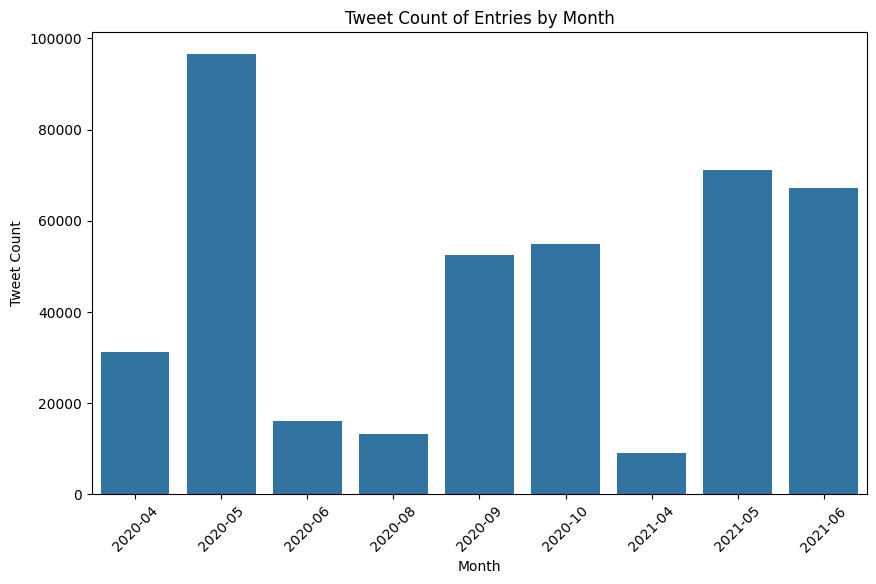

In [66]:
# Convert 'created_at' to datetime if it's not already
df['created_at'] = pd.to_datetime(df['created_at'])

# Extract year-month from 'created_at'
df['year_month'] = df['created_at'].dt.to_period('M')

# Count occurrences within each month
df_monthly = df.groupby('year_month').size().reset_index(name='count')

# Plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.barplot(x='year_month', y='count', data=df_monthly)
plt.xlabel('Month')
plt.ylabel('Tweet Count')
plt.title('Tweet Count of Entries by Month')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

### Sentiments Countplot


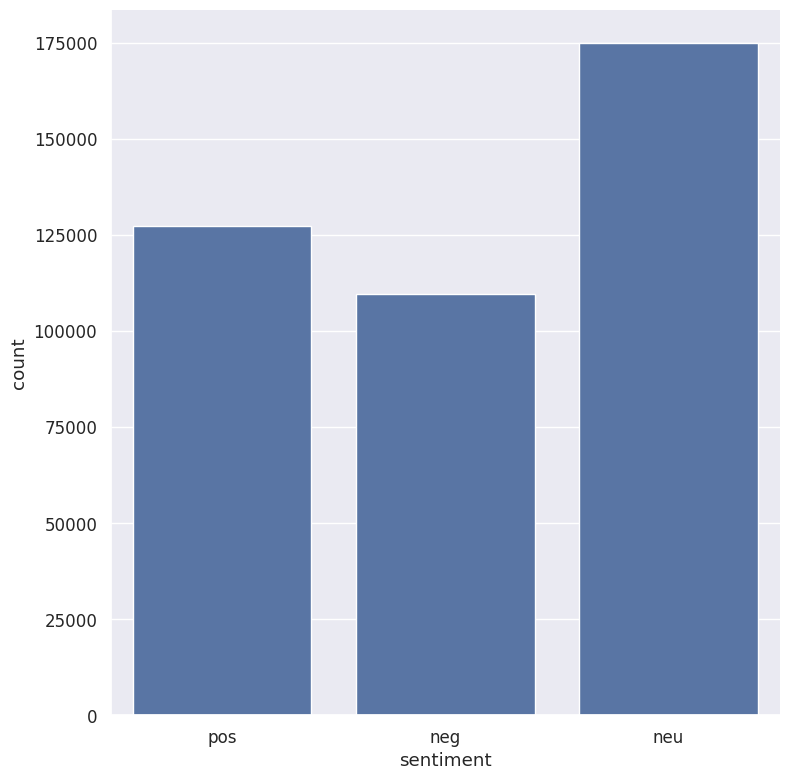

In [67]:
sns.set(font_scale=1.1)
sns.catplot(x="sentiment", data=df, kind="count", height=8)

## **<span style="color:blue;">Story Generation and Visualization from Tweets</span>**

What are the most common words in the entire dataset?

What are the most common words in the dataset for negative and positive tweets, respectively?

Which trends are associated with my dataset?

Which trends are associated with either of the sentiments? Are they compatible with the sentiments?


#### **A) Understanding the common words used in the tweets: WordCloud**


In [68]:
df.head(2)

id created_at  \
0  1.386694e+18 2021-04-26   
1  1.386694e+18 2021-04-26   

                                                                                 source  \
0  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   
1    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                                    original_text  \
0  RT @VP: The U.S. is working closely with the Indian government to rapidly deploy additional support and supplies during an alarming COVID-1â¦   
1                                         RT @JackPosobiec: Flip-Flop Fauci admits outdoor COVID transmission is very low https://t.co/6ztO7pOH1i   

  lang  favorite_count  retweet_count  original_author hashtags user_mentions  \
0   en             0.0            0.0  jfd4humanrights      NaN            VP   
1   en             0.0            0.0      andgrateful      NaN  JackPosobiec   

     place  \
0  Alabama   
1      NaN   

                                                                   clean_tweet  \
0   work close indian govern rapidli deploy addit support suppli alarm covid19   
1                          flip flop fauci admit outdoor covid19 transmiss low   

   compound    neg    neu    pos sentiment year_month  
0    0.0772  0.170  0.638  0.191       pos    2021-04  
1   -0.4019  0.398  0.442  0.159       neg    2021-04

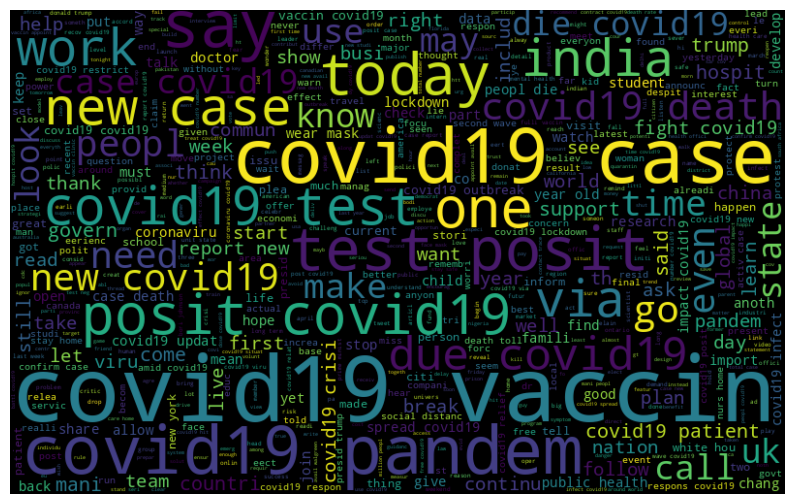

In [69]:
# create text from all tweets
# Remove NaN values from the list comprehension
all_words = " ".join([str(text) for text in df["clean_tweet"] if pd.notnull(text)])

from wordcloud import WordCloud

wordcloud = WordCloud(
    width=800, height=500, random_state=21, max_font_size=110, stopwords=None, max_words=None
).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

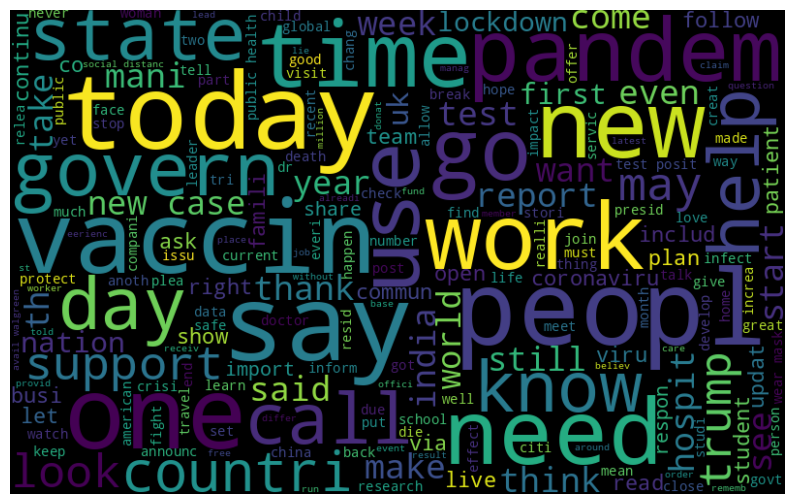

In [70]:


# Define common words to exclude
common_words = ["covid", "19", "covid19"]

# Generate a regular expression pattern to match variations of common words
pattern = r'\b(?:{})\b'.format('|'.join(common_words))

# Join all non-null clean_tweet texts, excluding common words and their variations
all_words = " ".join([str(text) for text in df["clean_tweet"] if pd.notnull(text) and not re.search(pattern, text, flags=re.IGNORECASE)])

# Generate word cloud with custom stopwords and unlimited maximum number of words
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

# Plot the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


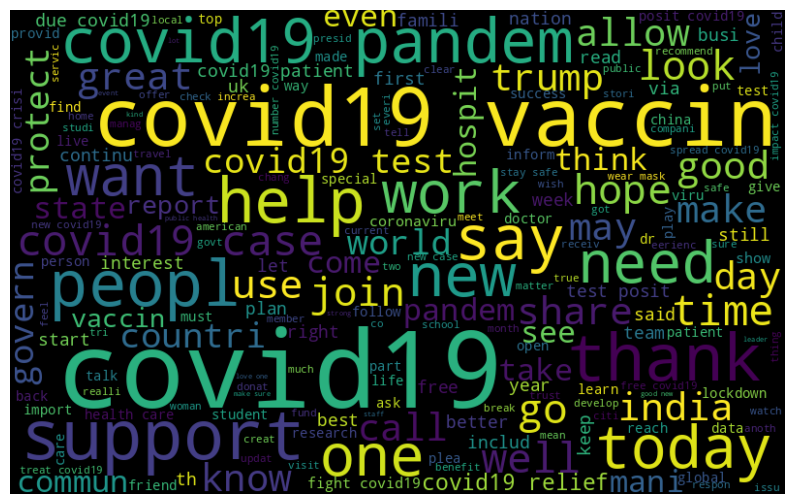

In [71]:
# create text from just normal tweets
normal_words = " ".join([text for text in df["clean_tweet"][df["sentiment"] == "pos"]])

wordcloud = WordCloud(
    width=800, height=500, random_state=21, max_font_size=110
).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

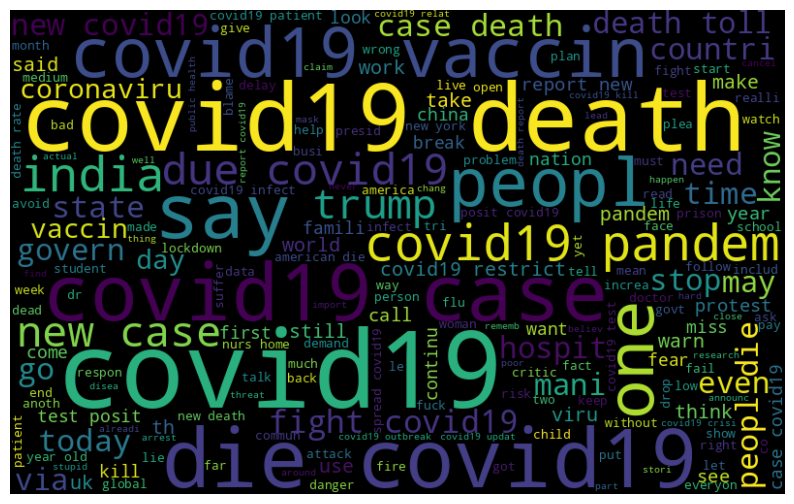

In [72]:
# create text from just normal tweets
normal_words = " ".join([text for text in df["clean_tweet"][df["sentiment"] == "neg"]])

wordcloud = WordCloud(
    width=800, height=500, random_state=21, max_font_size=110
).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

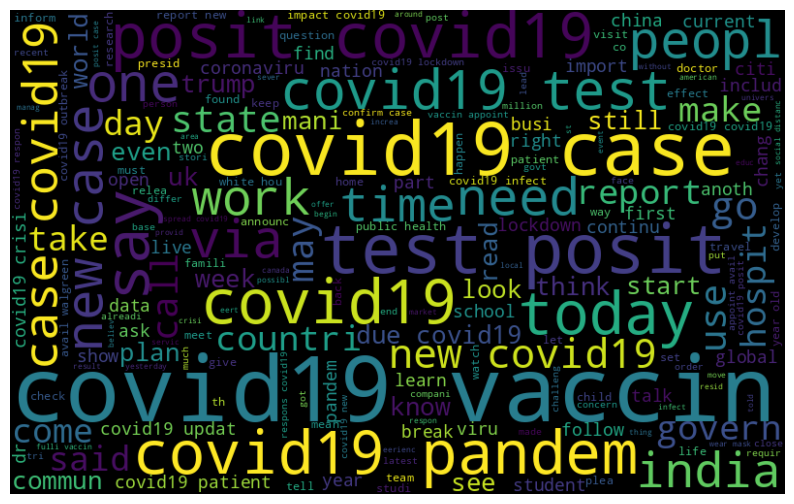

In [73]:
# create text from just normal tweets
normal_words = " ".join(
    [text for text in df["clean_tweet"][df["sentiment"] == "neu"] if pd.notnull(text)]
)

wordcloud = WordCloud(
    width=800, height=500, random_state=21, max_font_size=110
).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [74]:
import networkx as nx

G = nx.Graph()

# Add original authors as nodes
original_authors = set(df["original_author"].dropna().str.strip().unique())
G.add_nodes_from(original_authors, node_type="tweeting")

# Add mentioned users as nodes and edges
for _, row in df.iterrows():
    original_author = row["original_author"]
    # Check if original_author is not null
    if pd.notnull(original_author):
        original_author = original_author.strip()
        if pd.notnull(row["user_mentions"]):
            mentioned_users = [user.strip() for user in row["user_mentions"].split(",")]
            for mentioned_user in mentioned_users:
                if mentioned_user not in original_authors:
                    G.add_node(mentioned_user, node_type="mentioned")
                G.add_edge(original_author, mentioned_user)


In [ ]:
# Print number of nodes and edges
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 318869
Number of edges: 260990


In [ ]:
degree_dict = dict(G.degree())

In [ ]:
# Sort nodes by degree in descending order and get the top 5
top_10_degrees = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]

# Print the top 5 nodes with their degrees
print("Top Degree Nodes:")
for node, degree in top_10_degrees:
    print(f"{node} - Degree: {degree}")

Top Degree Nodes:
realDonaldTrump - Degree: 3740
YouTube - Degree: 763
CNN - Degree: 641
JoeBiden - Degree: 630
narendramodi - Degree: 606
SkyNews - Degree: 561
WHO - Degree: 545
BorisJohnson - Degree: 512
Reuters - Degree: 466
ABC - Degree: 462


In [ ]:
# Identify top degree nodes that are only mentioned
top_degree_mentioned = [node for node, degree in degree_dict.items() if degree > 0 and G.nodes[node]["node_type"] == "mentioned"]
top_degree_mentioned.sort(key=lambda x: degree_dict[x], reverse=True)

In [ ]:
# Print top degree mentioned nodes
print("Top Degree Mentioned Nodes:")
for node in top_degree_mentioned[:10]:
    print(node, "- Degree:", degree_dict[node])

Top Degree Mentioned Nodes:
realDonaldTrump - Degree: 3740
YouTube - Degree: 763
JoeBiden - Degree: 630
narendramodi - Degree: 606
PMOIndia - Degree: 347
NYGovCuomo - Degree: 318
POTUS - Degree: 301
WhiteHouse - Degree: 251
BBCNews - Degree: 189
GOP - Degree: 181


In [ ]:
top_degree_tweeting = [node for node, degree in degree_dict.items() if degree > 0 and G.nodes[node]["node_type"] == "tweeting"]
top_degree_tweeting.sort(key=lambda x: degree_dict[x], reverse=True)

# Print top degree tweeting nodes
print("Top Degree Tweeting Nodes:")
for node in top_degree_tweeting[:10]:
    print(node, "- Degree:", degree_dict[node])

Top Degree Tweeting Nodes:
CNN - Degree: 641
SkyNews - Degree: 561
WHO - Degree: 545
BorisJohnson - Degree: 512
Reuters - Degree: 466
ABC - Degree: 462
thehill - Degree: 380
MattHancock - Degree: 360
NBCNews - Degree: 318
guardian - Degree: 306


In [ ]:
# Calulate the average degree of the network
degrees = [d for n, d in G.degree()]
print("Average degree:", sum(degrees) / len(degrees))

Average degree: 1.6369731770727163


In [ ]:
# Calculate the degree frequency
degree_counts = {}


for degree in degrees:

    if degree in degree_counts:

        degree_counts[degree] += 1

    else:

        degree_counts[degree] = 1

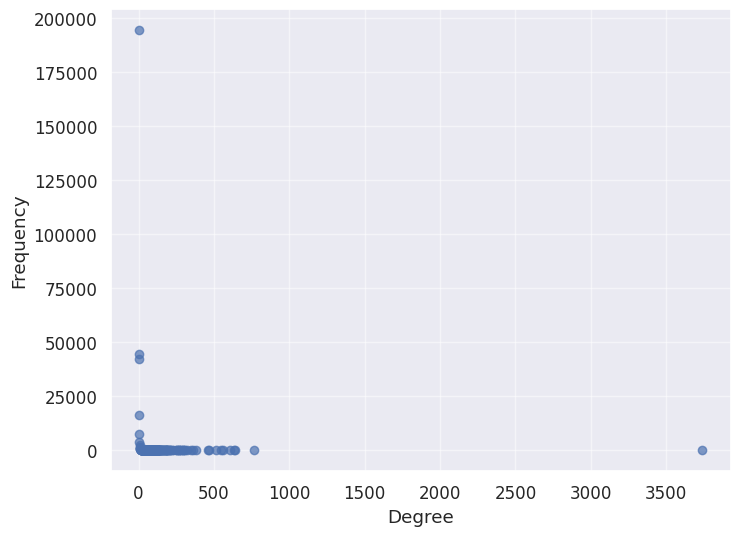

In [ ]:
import matplotlib.pyplot as plt

# Degree Distribution
sorted_degrees = sorted(degree_counts.keys())
freq = [degree_counts[degree] for degree in sorted_degrees]

plt.figure(figsize=(8, 6))
plt.scatter(sorted_degrees, freq, alpha=0.7)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

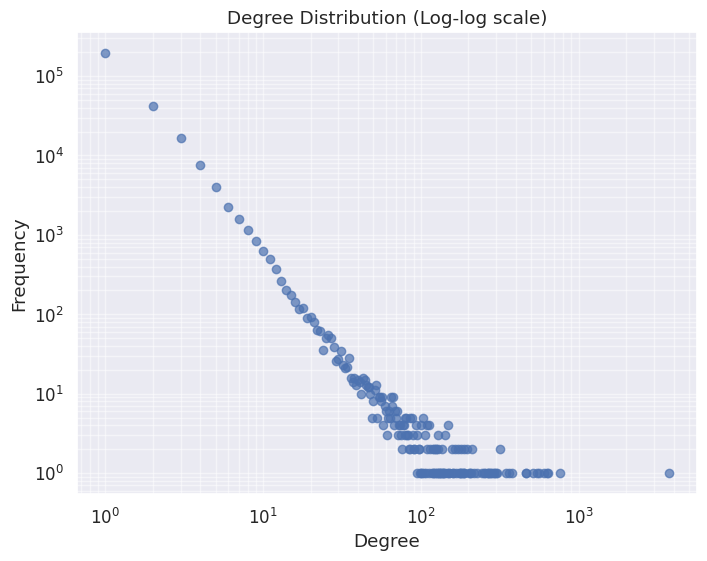

In [ ]:
# Plot the degree distribution on a log-log scale
plt.figure(figsize=(8, 6))
plt.scatter(sorted_degrees, freq, alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.title('Degree Distribution (Log-log scale)')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

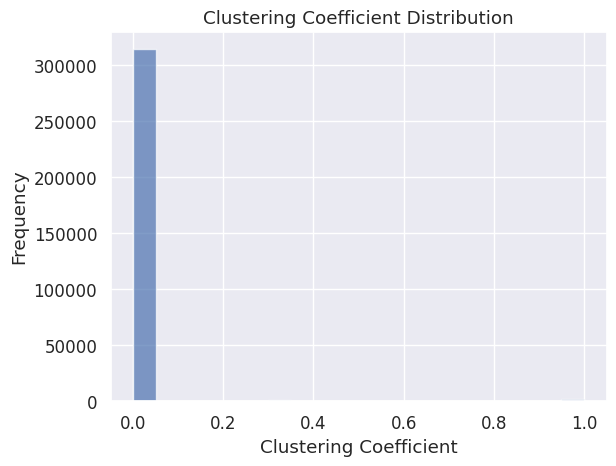

In [ ]:
clustering_coeffs = nx.clustering(G)
plt.hist(clustering_coeffs.values(), bins=20, alpha=0.7)
plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')
plt.title('Clustering Coefficient Distribution')
plt.show()


In [ ]:
connected_components = list(nx.connected_components(G))
print(len(connected_components))

94871


In [ ]:
gcc = max(connected_components, key=len)
gcc_graph = G.subgraph(gcc)

In [ ]:
gcc_nodes = gcc_graph.number_of_nodes()
gcc_edges = gcc_graph.number_of_edges()
print("GCC has", gcc_nodes, "nodes and", gcc_edges, "edges.")

GCC has 147819 nodes and 181585 edges.


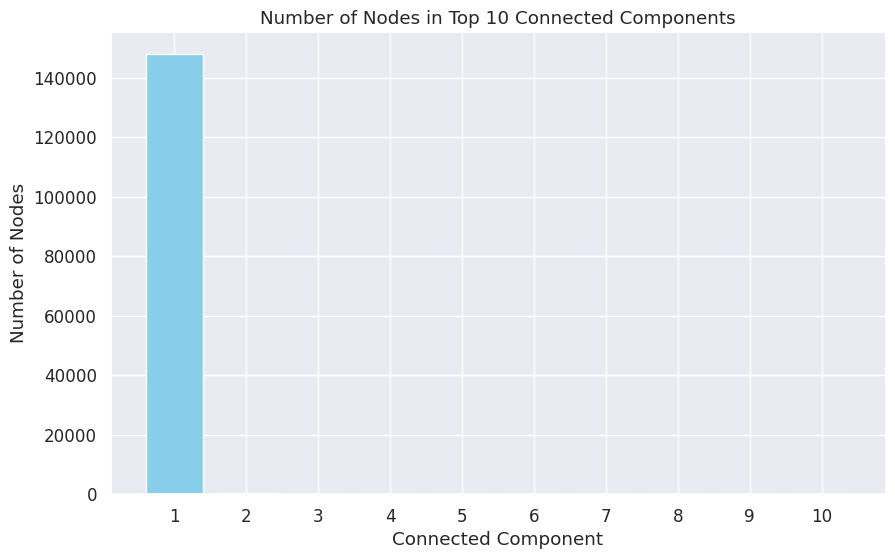

In [ ]:
# Sort connected components by size
sorted_cc = sorted(connected_components, key=len, reverse=True)

# Get the sizes of the top 10 connected components
top_10_cc = sorted_cc[:10]

# Get the sizes of the top 10 connected components
top_cc_sizes = [len(cc) for cc in top_10_cc]

# Plot the bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(range(1, len(top_cc_sizes) + 1), top_cc_sizes, color='skyblue')
plt.xlabel('Connected Component')
plt.ylabel('Number of Nodes')
plt.title('Number of Nodes in Top 10 Connected Components')
plt.xticks(range(1, len(top_cc_sizes) + 1))
plt.show()

In [80]:
df = pd.read_csv(
    "./archive/Covid-19 Twitter Dataset (Aug-Sep 2020).csv", encoding="latin-1"
)

**Understanding the impact of Hashtags on tweets sentiment**


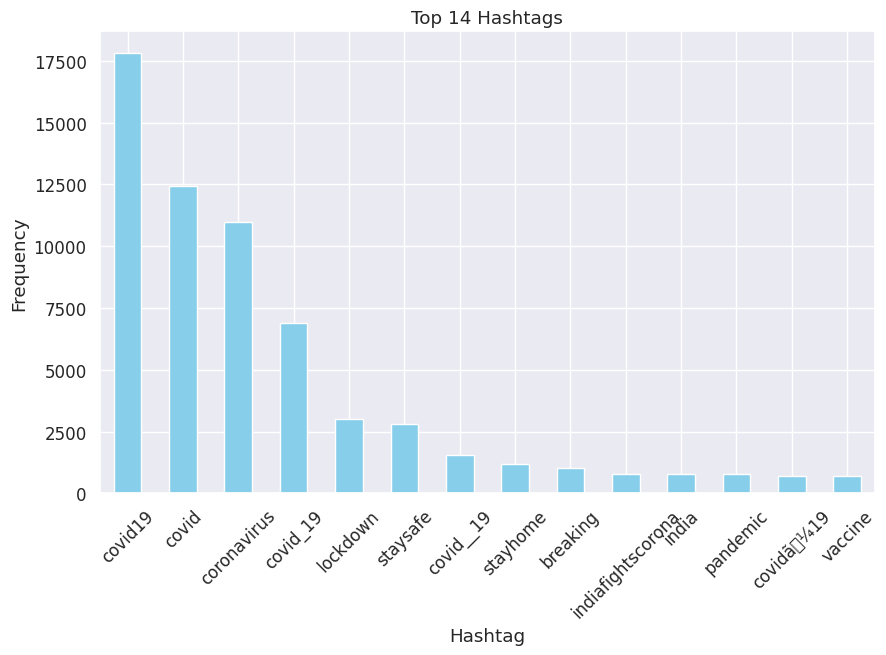

In [75]:
# Filter out NaN values in the 'hashtags' column
dfht = df.dropna(subset=['hashtags'])

# Extract hashtags
hashtags = dfht['hashtags'].str.lower().str.split(', ')

# Flatten the list of hashtags
all_hashtags = [tag for sublist in hashtags for tag in sublist]

# Count hashtag frequencies
hashtag_counts = pd.Series(all_hashtags).value_counts()

# Plot the top N hashtags
top_n = 14
plt.figure(figsize=(10, 6))
hashtag_counts.head(top_n).plot(kind='bar', color='skyblue')
plt.title('Top {} Hashtags'.format(top_n))
plt.xlabel('Hashtag')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


In [76]:
# Filter data by sentiment
positive_data = df[df['sentiment'] == 'pos']
negative_data = df[df['sentiment'] == 'neg']
neutral_data = df[df['sentiment'] == 'neu']

# Function to extract hashtags from a given DataFrame
def extract_hashtags(data):
    hashtags = data['hashtags'].dropna()  # Remove NaN values
    hashtags = hashtags.str.lower().str.split(', ')  # Split hashtags by comma and convert to lowercase
    hashtags = [tag for sublist in hashtags for tag in sublist]  # Flatten the list of hashtags
    return hashtags

# Extract hashtags for each sentiment category
positive_hashtags = extract_hashtags(positive_data)
negative_hashtags = extract_hashtags(negative_data)
neutral_hashtags = extract_hashtags(neutral_data)

# Print example hashtags for each sentiment
print("Positive Hashtags:", positive_hashtags[:10])
print("Negative Hashtags:", negative_hashtags[:10])
print("Neutral Hashtags:", neutral_hashtags[:10])


Positive Hashtags: ['covid19', 'vaccines', 'covid19', 'covid', 'tncoronaupdate', 'covid19', 'australia', 'hockey', 'ranirampal', 'indiafightscorona']
Negative Hashtags: ['india', 'covid', 'china', 'communists', 'sosiyc', 'covidemergency2021', 'ncoc', 'mewithnashik', 'covid19india', 'socialdistancing']
Neutral Hashtags: ['vizag', 'gitam', 'gaytri', 'gitam', 'gayatri', 'covid', 'sosiyc', 'shafqatmahmood', 'studentslivesmatter', 'studentsrejectpti']


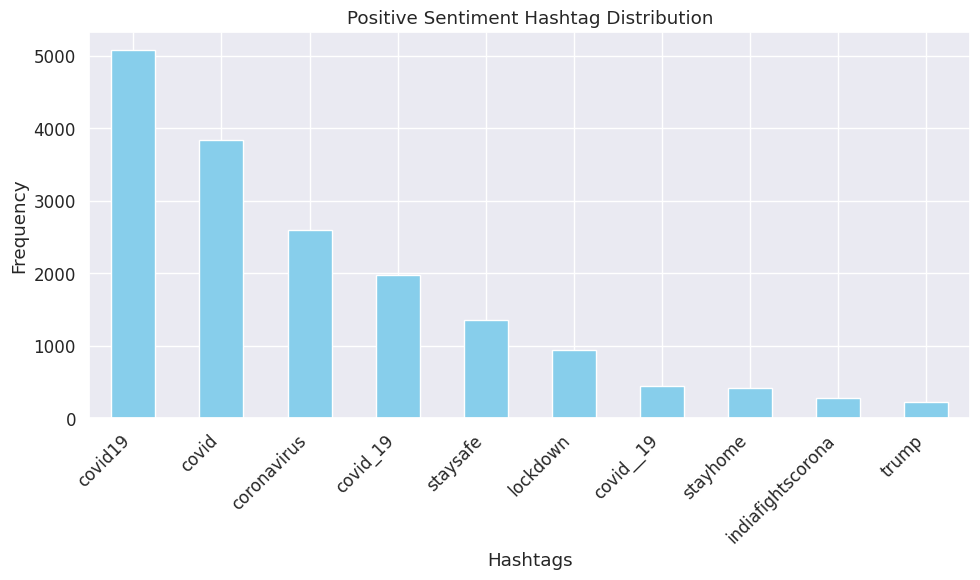

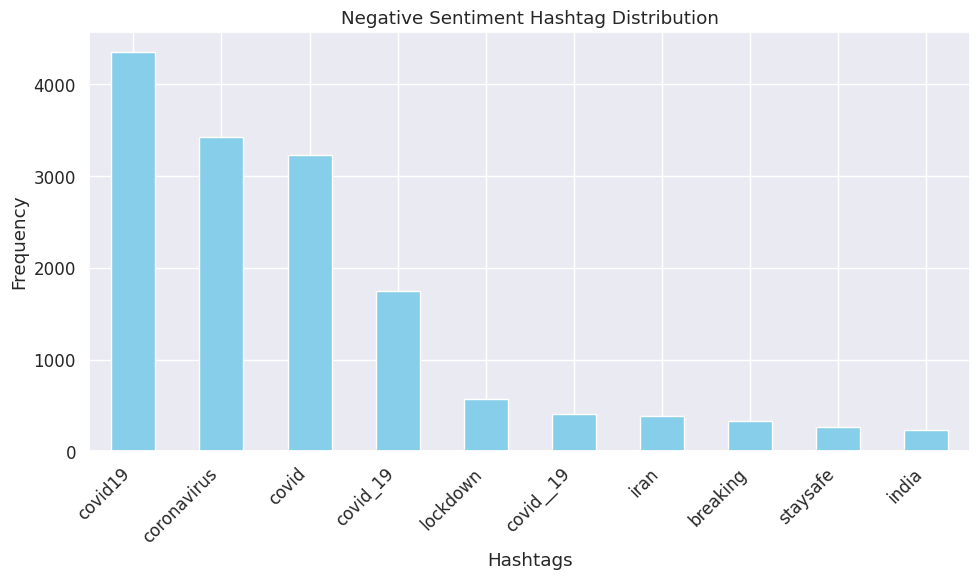

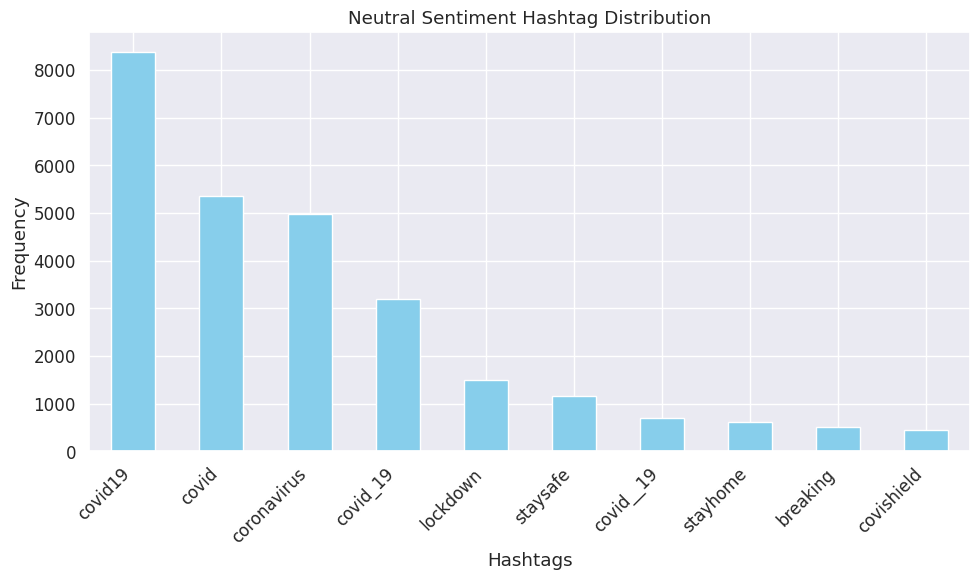

In [77]:
# Function to plot hashtag distribution
def plot_hashtag_distribution(hashtags, title):
    hashtag_counts = pd.Series(hashtags).value_counts().head(10)  # Get the top 10 most common hashtags
    plt.figure(figsize=(10, 6))
    hashtag_counts.plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel('Hashtags')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

# Plot hashtag distribution for each sentiment category
plot_hashtag_distribution(positive_hashtags, 'Positive Sentiment Hashtag Distribution')
plot_hashtag_distribution(negative_hashtags, 'Negative Sentiment Hashtag Distribution')
plot_hashtag_distribution(neutral_hashtags, 'Neutral Sentiment Hashtag Distribution')


In [78]:
hashtag_counts.head(14)

covid19              17805
covid                12423
coronavirus          11000
covid_19              6906
lockdown              3007
staysafe              2794
covid__19             1563
stayhome              1168
breaking              1017
indiafightscorona      797
india                  789
pandemic               789
covidã¼19             712
vaccine                685
Name: count, dtype: int64

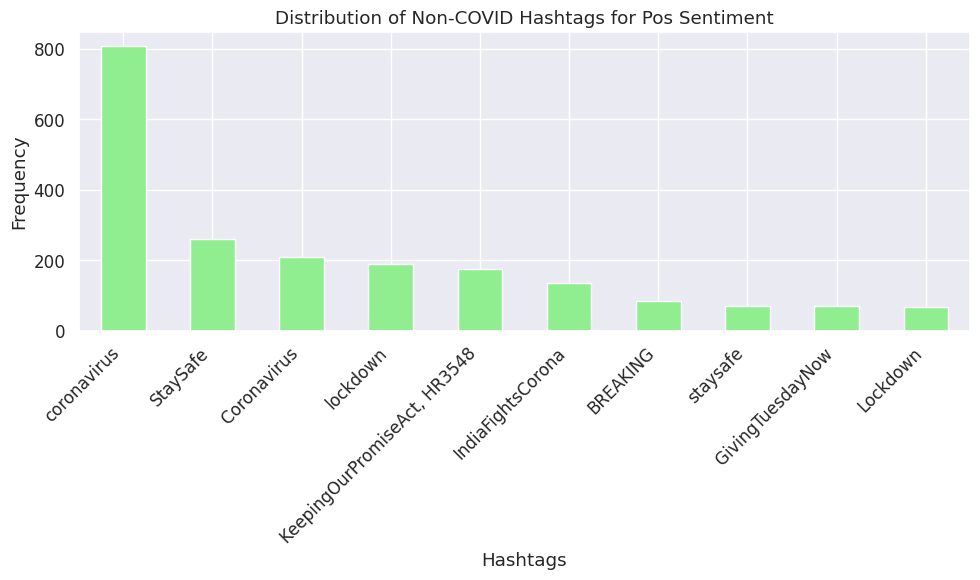

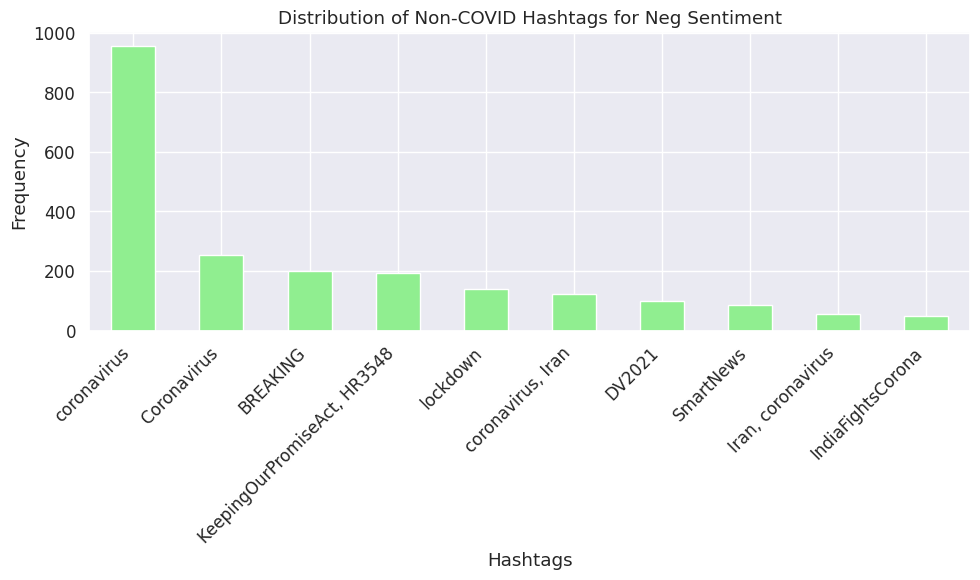

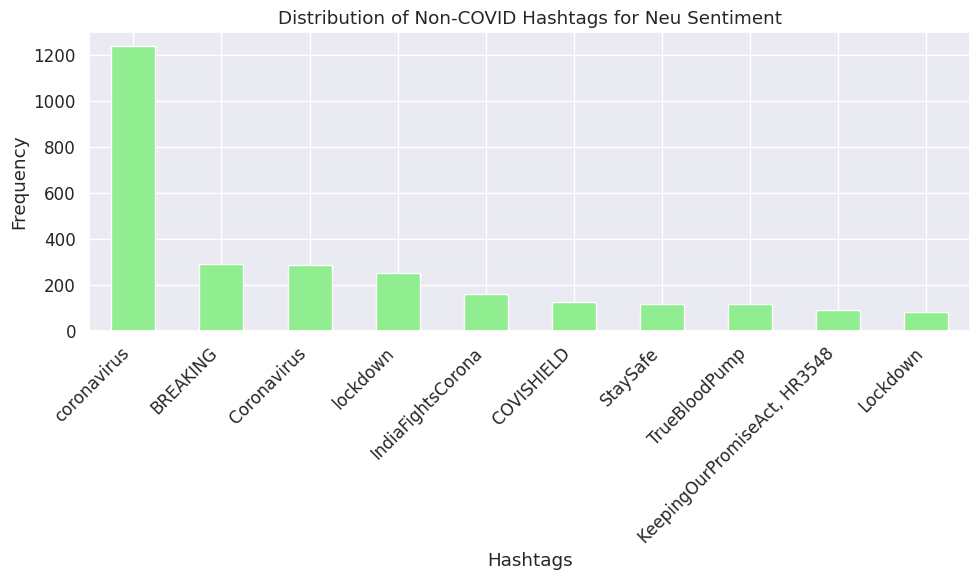

In [79]:
def plot_other_hashtag_distribution_for_sentiment(df, sentiment):
    # Filter hashtags that do not contain 'covid' and belong to the specified sentiment
    other_hashtags = df[(df['hashtags'].str.lower().str.contains('covid') == False) & (df['sentiment'] == sentiment)]['hashtags'].dropna()

    # Plot distribution of other hashtags
    other_hashtags_counts = other_hashtags.value_counts().head(10)  # Get the top 10 most common other hashtags
    plt.figure(figsize=(10, 6))
    other_hashtags_counts.plot(kind='bar', color='lightgreen')
    plt.title(f'Distribution of Non-COVID Hashtags for {sentiment.capitalize()} Sentiment')
    plt.xlabel('Hashtags')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

# Iterate over each sentiment category and plot distribution of non-COVID-related hashtags
sentiments = ['pos', 'neg', 'neu']
for sentiment in sentiments:
    plot_other_hashtag_distribution_for_sentiment(df, sentiment)

**Building the network for the Aug-Sep 2020 Dataset**

In [ ]:
import networkx as nx

In [81]:
G = nx.Graph()

# Add original authors as nodes
original_authors = set(df["original_author"].dropna().str.strip().unique())
G.add_nodes_from(original_authors, node_type="tweeting")

# Add mentioned users as nodes and edges
for _, row in df.iterrows():
    original_author = row["original_author"]
    # Check if original_author is not null
    if pd.notnull(original_author):
        original_author = original_author.strip()
        if pd.notnull(row["user_mentions"]):
            mentioned_users = [user.strip() for user in row["user_mentions"].split(",")]
            for mentioned_user in mentioned_users:
                if mentioned_user not in original_authors:
                    G.add_node(mentioned_user, node_type="mentioned")
                G.add_edge(original_author, mentioned_user)


In [82]:
# Print number of nodes and edges
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 153238
Number of edges: 117468


In [83]:
degree_dict = dict(G.degree())

In [84]:
connected_components = list(nx.connected_components(G))
print(len(connected_components))

49456


In [85]:
gcc = max(connected_components, key=len)
gcc_graph = G.subgraph(gcc)

In [86]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(gcc_graph)


In [ ]:
# Function to get top influential users
def get_top_users(measure, node_type, top_n=10):
    top_users = [(user, measure[user]) for user in gcc_graph.nodes if gcc_graph.nodes[user]["node_type"] == node_type]
    top_users.sort(key=lambda x: x[1], reverse=True)
    return top_users[:top_n]

# Get top tweeted users based on degree centrality
top_tweet_users_degree = get_top_users(degree_centrality, "tweeting")

# Get top mentioned users based on degree centrality
top_mentioned_users_degree = get_top_users(degree_centrality, "mentioned")

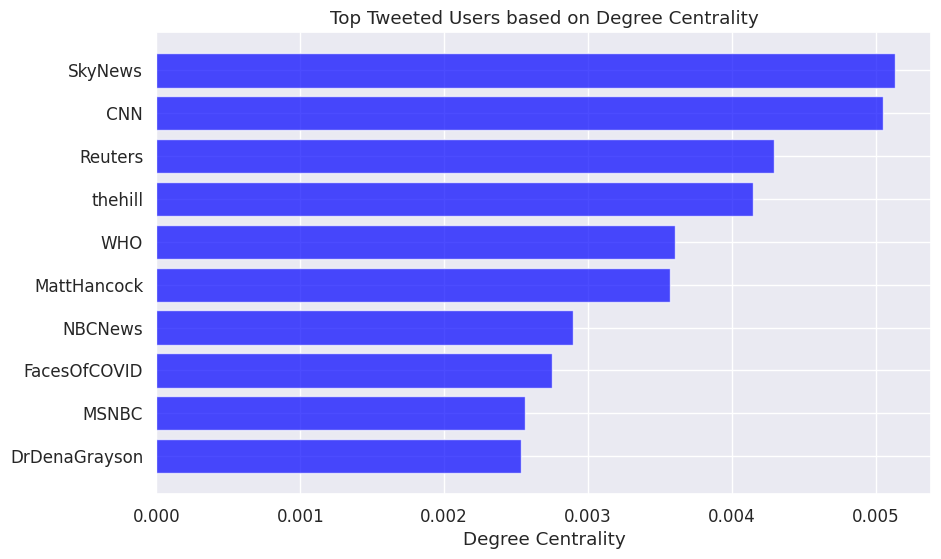

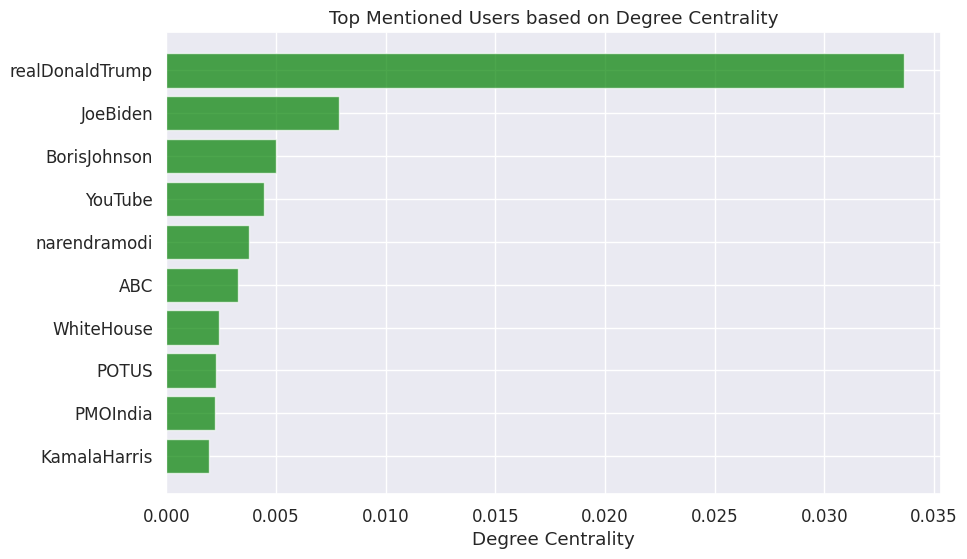

In [ ]:
# Extract users and centrality values
tweeted_users, tweeted_values = zip(*top_tweet_users_degree)
mentioned_users, mentioned_values = zip(*top_mentioned_users_degree)

# Plot bar plot for top tweeted users
plt.figure(figsize=(10, 6))
plt.barh(tweeted_users, tweeted_values, color='blue', alpha=0.7)
plt.xlabel('Degree Centrality')
plt.title('Top Tweeted Users based on Degree Centrality')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest degree at the top
plt.show()

# Plot bar plot for top mentioned users
plt.figure(figsize=(10, 6))
plt.barh(mentioned_users, mentioned_values, color='green', alpha=0.7)
plt.xlabel('Degree Centrality')
plt.title('Top Mentioned Users based on Degree Centrality')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest degree at the top
plt.show()

In [ ]:
# Initialize dictionaries to store sentiment scores
tweeted_sentiments = {}
mentioned_sentiments = {}

# Filter DataFrame for top tweeted users
top_tweet_users = [user for user, _ in top_tweet_users_degree]

# Filter DataFrame for top mentioned users
top_mentioned_users = [user for user, _ in top_mentioned_users_degree]

# Calculate average sentiment scores for top tweeted users
for user in top_tweet_users:
    user_tweets = df[df["original_author"] == user]
    avg_sentiment = user_tweets["compound"].mean()
    tweeted_sentiments[user] = avg_sentiment

# Calculate average sentiment scores for top mentioned users
for user in top_mentioned_users:
    user_mentions = df[df["user_mentions"].str.contains(user, na=False)]
    avg_sentiment = user_mentions["compound"].mean()
    mentioned_sentiments[user] = avg_sentiment


In [ ]:
# Convert to DataFrame for neat printing
df_tweeted_sentiments = pd.DataFrame(tweeted_sentiments.items(), columns=['User', 'Average Sentiment Score (Tweeted)'])
df_mentioned_sentiments = pd.DataFrame(mentioned_sentiments.items(), columns=['User', 'Average Sentiment Score (Mentioned)'])

# Print the sentiment scores of top tweeted users
print("Sentiment Scores of Top Tweeted Users:")
df_tweeted_sentiments

Sentiment Scores of Top Tweeted Users:


User  Average Sentiment Score (Tweeted)
0        SkyNews                          -0.165853
1            CNN                           0.028025
2        Reuters                          -0.476700
3        thehill                          -0.180000
4            WHO                           0.648600
5    MattHancock                           0.000000
6        NBCNews                          -0.085267
7   FacesOfCOVID                          -0.599400
8          MSNBC                          -0.299700
9  DrDenaGrayson                          -0.172000

In [ ]:
# Print the sentiment scores of top mentioned users
print("\nSentiment Scores of Top Mentioned Users:")
df_mentioned_sentiments


Sentiment Scores of Top Mentioned Users:


User  Average Sentiment Score (Mentioned)
0  realDonaldTrump                            -0.089025
1         JoeBiden                            -0.061883
2     BorisJohnson                            -0.060986
3          YouTube                            -0.038266
4     narendramodi                             0.049291
5              ABC                            -0.064868
6       WhiteHouse                            -0.047091
7            POTUS                            -0.063093
8         PMOIndia                             0.042334
9     KamalaHarris                            -0.028825

In [ ]:
# Define a function to assign initial sentiment scores to users
def assign_initial_sentiment_scores(df):
    # Calculate average sentiment score for each tweeting user
    avg_sentiment_scores = df.groupby("original_author")["compound"].mean().to_dict()
    return avg_sentiment_scores

# Define a function to propagate sentiment scores through the network
def propagate_sentiment_scores(G, initial_sentiment_scores):
    # Initialize sentiment scores dictionary with initial scores
    sentiment_scores = initial_sentiment_scores.copy()

    # Propagate sentiment scores through the network
    for edge in G.edges():
        source, target = edge
        # Propagate sentiment score from source to target
        sentiment_scores[target] = sentiment_scores.get(target, 0) + sentiment_scores.get(source, 0)

    return sentiment_scores

In [ ]:
# Define a function to calculate degree centrality
def calculate_degree_centrality(G):
    degree_centrality = nx.degree_centrality(G)
    return degree_centrality

In [ ]:
# Assign initial sentiment scores
initial_sentiment_scores = assign_initial_sentiment_scores(df)

# Propagate sentiment scores through the network
propagated_sentiment_scores = propagate_sentiment_scores(G, initial_sentiment_scores)

# Sort users by their propagated sentiment scores
sorted_users_by_sentiment = sorted(propagated_sentiment_scores.items(), key=lambda x: x[1], reverse=True)

# Convert to DataFrame for neat printing
df_sorted_users = pd.DataFrame(sorted_users_by_sentiment, columns=['User', 'Propagated Sentiment Score'])

# Calculate degree centrality
degree_centrality = calculate_degree_centrality(G)

# Convert degree centrality to DataFrame
df_degree_centrality = pd.DataFrame(list(degree_centrality.items()), columns=['User', 'Degree Centrality'])

# Merge sentiment scores and degree centrality
df_sentiment_degree = pd.merge(df_sorted_users, df_degree_centrality, on='User', how='left')

# Print the top users with highest propagated sentiment scores and their degree centrality
print("Top Users with Highest Propagated Sentiment Scores and Degree Centrality:")
df_sentiment_degree.head(20)

Top Users with Highest Propagated Sentiment Scores and Degree Centrality:


User  Propagated Sentiment Score  Degree Centrality
0      narendramodi                  623.197838           0.001501
1          PMOIndia                  530.465669           0.000874
2       DrRPNishank                  448.343260           0.000535
3            DG_NTA                  309.101022           0.000150
4     EduMinOfIndia                  288.070956           0.000235
5    transformIndia                  235.520718           0.000072
6          PIBHindi                  219.964859           0.000046
7      Joee_Blackkk                  207.078884           0.000124
8      chiba3111218                  188.557968           0.000013
9         JeannyTSY                  188.340468           0.000007
10  Saku_saku_marey                  188.284068           0.000007
11       Amber02150                  187.613568           0.000170
12    AntheiaGrecia                  187.613568           0.000007
13     BorisJohnson                  135.493235           0.001990
14        MIB_Hindi                  120.454661           0.000020
15           PIBHRD                  109.889742           0.000020
16      DDNewsHindi                  109.835442           0.000013
17  Shivamn18639288                  109.687442           0.000072
18     AdvRamSingh3                  109.687442           0.000007
19     HardeepSPuri                  100.239875           0.000039

These results show the influential users and entities whose tweets have had the most significant impact on shaping sentiment within the network. Higher scores indicate a more significant influence on the sentiment of other users.

The algorithm starts with initial sentiment scores assigned to each user based on their individual tweets. These initial scores could be based on sentiment analysis of the text content of the tweets. As the algorithm iterates through the network, it propagates sentiment scores from one user to another based on their interactions.

Users with higher sentiment scores are considered to have a greater influence on the sentiment of others. When they interact with other users, they transfer a portion of their sentiment score to them.
When these influential users interact with other users by retweeting, mentioning, or replying, they transfer a portion of their sentiment score to those users.

As a result, users with higher sentiment scores have a more significant impact on shaping the sentiment of others in the network.
The propagation algorithm considers the strength of the connection between users (e.g., the number of interactions, the frequency of interactions) and the sentiment of the source user to determine the amount of sentiment transferred.


**Community Analysis**

**Forming Communities for the top degree nodes**

In [88]:
# Sort nodes by degree in descending order and get the top 5
top_degrees = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]

# Print the top 5 nodes with their degrees
print("Top Degree Nodes:")
for node, degree in top_degrees:
    print(f"{node} - Degree: {degree}")

Top Degree Nodes:
realDonaldTrump - Degree: 2046
JoeBiden - Degree: 479
SkyNews - Degree: 312
CNN - Degree: 307
BorisJohnson - Degree: 305
YouTube - Degree: 270
Reuters - Degree: 261
thehill - Degree: 252
narendramodi - Degree: 230
WHO - Degree: 219


**Forming communities for the gaint connected components**

In [91]:
gcc_nodes = gcc_graph.number_of_nodes()
gcc_edges = gcc_graph.number_of_edges()
print("GCC has", gcc_nodes, "nodes and", gcc_edges, "edges.")

GCC has 60799 nodes and 72710 edges.


In [ ]:

# Perform community detection on the subgraph
communities = nx.algorithms.community.greedy_modularity_communities(gcc_graph)

# Print the communities
print("Communities of Top Degree Nodes:")
for i, community in enumerate(communities, start=1):
    print(f"Community {i}: {community}")

In [97]:
# Print the communities
print("Communities of Top Degree Nodes:")
for i, community in enumerate(communities, start=1):
    print(f"Community {i}: {community}")
    if i == 15:
        break

Communities of Top Degree Nodes:
Community 1: frozenset({'4sutq8', 'Manuforti54', 'JanFred1903', 'arabpuppy', 'Jebba11', 'DiscoDog15', 'NSACyber', 'sergius_south', 'dancingonapin', 'fulin125', 'Bubba20889194', 'hdrapeaux', 'dwgknz', 'DarrenJBeattie', '3373Jones', 'JamesOKeefeIII', 'jplinde', 'Stellablue9', 'mycatisjack', 'lynmacjay', 'janeandjohn', '1manfilmcrew', 'chipfranklin', 'brahamThinkin', 'journeyheart', 'Anilaug3', 'jbarb1990', 'Chrismoore5203', 'Stonefree63', 'EjezieUgo', 'Lip6781', 'MicaSoellner', 'Kdrews4191', 'Jayne720', 'Millions4Trump2', 'mrchecketts', 'rizlaplusplus', 'DenbrotS', 'jhjulian1956', '1Nastygal', 'hplem', 'candiceVT159', 'Eades_Tweets', 'bdove7777', 'JaneCurran19', 'mhawk1220', 'CherylB12988389', 'SuelouiseS', 'mikandynothem', 'slidewinding', 'welchgrapesrus', 'Vi44', 'ktarpetersamore', 't_turnet', 'Rob_AirOne', 'babydollgolf', 'p411nd0m3', 'PatriciaBannach', 'eraseism', 'DonaldJTrumpJr', 'Malwill08', 'Pedro_ChosenOne', 'mtnrunfx', 'BKR0822', 'WHNSC', 'Linda

In [93]:
def analyze_sentiment_trends(sentiment_scores):
    # Example implementation: Calculate average sentiment score
    total_positive = len(sentiment_scores['pos'])
    total_negative = len(sentiment_scores['neg'])
    total_neutral = len(sentiment_scores['neu'])

    total_entries = total_positive + total_negative + total_neutral

    if total_entries == 0:
        print("No sentiment data available for this community.")
        return

    # Calculate proportions
    positive_proportion = total_positive / total_entries
    negative_proportion = total_negative / total_entries
    neutral_proportion = total_neutral / total_entries

    print(f"Positive Proportion: {positive_proportion:.2f}")
    print(f"Negative Proportion: {negative_proportion:.2f}")
    print(f"Neutral Proportion: {neutral_proportion:.2f}")
    print("\n")


In [94]:
# Funtion to find the distribution of Sentiment across community
def compare_sentiment_distributions(community_sentiment):
    # Example implementation: Compare sentiment distributions between communities
    for community, sentiment_scores in community_sentiment.items():
        total_positive = len(sentiment_scores['pos'])
        total_negative = len(sentiment_scores['neg'])
        total_neutral = len(sentiment_scores['neu'])

        total_entries = total_positive + total_negative + total_neutral

        if total_entries == 0:
            print(f"No sentiment data available for Community {community}.")
            continue

        print(f"Sentiment Distribution for Community {community}:")
        print(f"Positive: {total_positive} entries")
        print(f"Negative: {total_negative} entries")
        print(f"Neutral: {total_neutral} entries")
        print()

In [98]:
# Sort communities based on their size (number of nodes)
sorted_communities = sorted(communities, key=len, reverse=True)

# Select the top 10 largest communities
top_10_communities = sorted_communities[:10]

# Assuming you have already loaded your dataset into the DataFrame df2 and detected communities
# Assuming you have the top 10 communities stored in the variable top_10_communities

# Initialize dictionaries to store sentiment scores for each community
community_sentiment = {i: {'pos': [], 'neg': [], 'neu': []} for i in range(1, 11)}

# Iterate over rows in your dataset
for _, row in df.iterrows():
    # Extract sentiment information from the dataset (e.g., sentiment)
    sentiment = row['sentiment']

    # Determine the community of the current row
    for i, community in enumerate(top_10_communities, start=1):
        if row['original_author'] in community:
            # Ensure that sentiment keys exist for the current community
            if sentiment not in community_sentiment[i]:
                community_sentiment[i][sentiment] = []  # Create an empty list for the sentiment if it doesn't exist
            # Aggregate sentiment scores for the current community
            community_sentiment[i][sentiment].append(row['created_at'])  # Assuming row['created_at'] is the timestamp
            break  # Stop searching for the community once it's found
        elif pd.notnull(row['user_mentions']):  # Check if user_mentions is not NaN
            user_mentions = str(row['user_mentions'])  # Convert to string to handle NaN values
            if any(mention in community for mention in user_mentions.split(',')):
                # Ensure that sentiment keys exist for the current community
                if sentiment not in community_sentiment[i]:
                    community_sentiment[i][sentiment] = []  # Create an empty list for the sentiment if it doesn't exist
                # Aggregate sentiment scores for the current community
                community_sentiment[i][sentiment].append(row['created_at'])  # Assuming row['created_at'] is the timestamp
                break  # Stop searching for the community once it's found

# Analyze sentiment trends within each community
for community, sentiment_scores in community_sentiment.items():
    # Calculate metrics such as average sentiment score or proportion of positive/negative/neutral rows
    print(f"Sentiment Trends of community {community}")
    analyze_sentiment_trends(sentiment_scores)


Sentiment Trends of community 1
Positive Proportion: 0.27
Negative Proportion: 0.38
Neutral Proportion: 0.36


Sentiment Trends of community 2
Positive Proportion: 0.29
Negative Proportion: 0.32
Neutral Proportion: 0.39


Sentiment Trends of community 3
Positive Proportion: 0.30
Negative Proportion: 0.22
Neutral Proportion: 0.48


Sentiment Trends of community 4
Positive Proportion: 0.24
Negative Proportion: 0.33
Neutral Proportion: 0.44


Sentiment Trends of community 5
Positive Proportion: 0.30
Negative Proportion: 0.24
Neutral Proportion: 0.46


Sentiment Trends of community 6
Positive Proportion: 0.29
Negative Proportion: 0.30
Neutral Proportion: 0.41


Sentiment Trends of community 7
Positive Proportion: 0.34
Negative Proportion: 0.23
Neutral Proportion: 0.43


Sentiment Trends of community 8
Positive Proportion: 0.27
Negative Proportion: 0.31
Neutral Proportion: 0.42


Sentiment Trends of community 9
Positive Proportion: 0.31
Negative Proportion: 0.20
Neutral Proportion: 0.49


S

In [99]:
# Compare sentiment distributions between communities
compare_sentiment_distributions(community_sentiment)

Sentiment Distribution for Community 1:
Positive: 1477 entries
Negative: 2090 entries
Neutral: 1969 entries

Sentiment Distribution for Community 2:
Positive: 1753 entries
Negative: 1982 entries
Neutral: 2374 entries

Sentiment Distribution for Community 3:
Positive: 783 entries
Negative: 564 entries
Neutral: 1250 entries

Sentiment Distribution for Community 4:
Positive: 694 entries
Negative: 955 entries
Neutral: 1281 entries

Sentiment Distribution for Community 5:
Positive: 722 entries
Negative: 587 entries
Neutral: 1127 entries

Sentiment Distribution for Community 6:
Positive: 486 entries
Negative: 517 entries
Neutral: 697 entries

Sentiment Distribution for Community 7:
Positive: 490 entries
Negative: 339 entries
Neutral: 615 entries

Sentiment Distribution for Community 8:
Positive: 278 entries
Negative: 312 entries
Neutral: 423 entries

Sentiment Distribution for Community 9:
Positive: 271 entries
Negative: 174 entries
Neutral: 428 entries

Sentiment Distribution for Community 

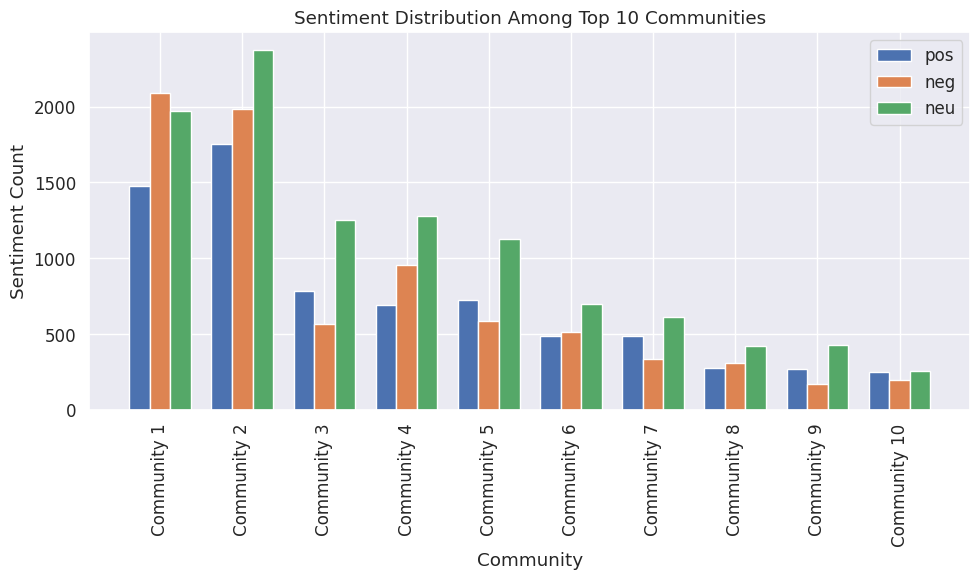

In [100]:

# Define sentiment categories
sentiments = ['pos', 'neg', 'neu']

# Initialize lists to store sentiment counts for each community
community_sentiment_counts = {sentiment: [] for sentiment in sentiments}

# Aggregate sentiment counts for each community
for community, sentiment_scores in community_sentiment.items():
    for sentiment in sentiments:
        sentiment_count = len(sentiment_scores.get(sentiment, []))
        community_sentiment_counts[sentiment].append(sentiment_count)

# Plot the bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.25
index = range(len(top_10_communities))

for i, sentiment in enumerate(sentiments):
    plt.bar([x + i * bar_width for x in index], community_sentiment_counts[sentiment], bar_width, label=sentiment)

plt.xlabel('Community')
plt.ylabel('Sentiment Count')
plt.title('Sentiment Distribution Among Top 10 Communities')
plt.xticks([x + bar_width for x in index], [f'Community {i}' for i in range(1, 11)], rotation = 90)
plt.legend()
plt.tight_layout()
plt.show()


**Top Influencers Overall and in top 10 Community**

In [101]:
influence_scores = nx.pagerank(gcc_graph, alpha=0.85)  # Using PageRank algorithm for ranking
sorted_influence = sorted(influence_scores.items(), key=lambda x: x[1], reverse=True)

# Select top influencers (e.g., top 10)
top_influencers = sorted_influence[:10]

print("Top Influencers:")
for user_id, influence_score in top_influencers:
    print(f"{user_id} - Influence Score: {influence_score:.4f}")

Top Influencers:
realDonaldTrump - Influence Score: 0.0111
JoeBiden - Influence Score: 0.0026
CNN - Influence Score: 0.0019
SkyNews - Influence Score: 0.0019
YouTube - Influence Score: 0.0019
Reuters - Influence Score: 0.0018
thehill - Influence Score: 0.0017
BorisJohnson - Influence Score: 0.0016
ABC - Influence Score: 0.0012
FacesOfCOVID - Influence Score: 0.0012


In [102]:
for i, community in enumerate(top_10_communities, start=1):
    print(f"Community {i}:")

    # Create a subgraph for the current community
    community_subgraph = gcc_graph.subgraph(community)

    # Calculate influence scores within the community
    influence_scores = nx.pagerank(community_subgraph, alpha=0.85)

    # Sort users by influence scores
    sorted_influence = sorted(influence_scores.items(), key=lambda x: x[1], reverse=True)

    # Select top influencers within the community (e.g., top 3)
    top_influencers = sorted_influence[:3]

    # Print top influencers and their influence scores
    for user_id, influence_score in top_influencers:
        print(f"{user_id} - Influence Score: {influence_score:.4f}")

    print()

Community 1:
realDonaldTrump - Influence Score: 0.0912
JoeBiden - Influence Score: 0.0206
Cleavon_MD - Influence Score: 0.0071

Community 2:
SkyNews - Influence Score: 0.0171
BorisJohnson - Influence Score: 0.0147
MattHancock - Influence Score: 0.0110

Community 3:
narendramodi - Influence Score: 0.0210
PMOIndia - Influence Score: 0.0111
COVIDNewsByMIB - Influence Score: 0.0105

Community 4:
CNN - Influence Score: 0.0366
NBCNews - Influence Score: 0.0223
ABC - Influence Score: 0.0217

Community 5:
CP24 - Influence Score: 0.0164
TorontoStar - Influence Score: 0.0151
CTVNews - Influence Score: 0.0120

Community 6:
CDCgov - Influence Score: 0.0191
TIME - Influence Score: 0.0189
NYGovCuomo - Influence Score: 0.0181

Community 7:
WHO - Influence Score: 0.0362
UN - Influence Score: 0.0130
citizentvkenya - Influence Score: 0.0117

Community 8:
rtenews - Influence Score: 0.0268
IrishTimes - Influence Score: 0.0188
HSELive - Influence Score: 0.0133

Community 9:
wef - Influence Score: 0.0462
Qu

# MissInformation Classification

Fact Scores Labesl which we used to train our BERT model


In [ ]:
# Define labels and scores
labels = ['false', 'half-true', 'mostly-true', 'true', 'barely-true', 'pants-fire']
scores = [-2, 0, 1, 2, -1, -3]

# Create a pandas DataFrame
df1 = pd.DataFrame({'Label': labels, 'Score': scores})

# Sort the DataFrame by the "Score" column
df_sorted = df1.sort_values(by='Score', ascending=False)

df_sorted.head(6)

Label  Score
3         true      2
2  mostly-true      1
1    half-true      0
4  barely-true     -1
0        false     -2
5   pants-fire     -3

In [ ]:
# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Map labels to scores
label_to_score = {
    0: -2,  # false
    1: 0,   # half-true
    2: 1,   # mostly-true
    3: 2,   # true
    4: -1,  # barely-true
    5: -3   # pants-fire
}

# Convert labels to scores
def convert_labels_to_scores(example):
    example['label'] = label_to_score[int(example['label'])]
    return example

# Tokenize the dataset with a maximum sequence length of 128 tokens
def tokenize_batch(batch):
    encoded_batch = tokenizer(batch['statement'], padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    encoded_batch['label'] = torch.tensor([label_to_score[label] for label in batch['label']])
    return encoded_batch

tokenized_dataset = dataset.map(tokenize_batch, batched=True)

# Convert labels to scores
#tokenized_dataset = tokenized_dataset.map(convert_labels_to_scores)


In [ ]:
#tokenized_dataset = tokenized_dataset.map(convert_labels_to_scores)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=8,
    num_train_epochs=3,
    logging_dir='./logs',
    logging_steps=500,
    evaluation_strategy="steps",
    eval_steps=500,
    save_steps=1000,
)

# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)  # Regression: num_labels=1

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test']
)


In [ ]:
from torch import nn

loss_fn = nn.MSELoss()

In [ ]:
# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Fine-tune the model
for epoch in range(training_args.num_train_epochs):
    # Reset the loss for each epoch
    total_loss = 0.0

    # Iterate over each batch in the training dataloader
    for batch in trainer.get_train_dataloader():
        # Move batch to GPU
        batch = {k: v.to(device) for k, v in batch.items()}

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(**batch)

        # Compute loss
        loss = loss_fn(outputs.logits.squeeze(), batch['labels'].float())

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Accumulate the loss for logging
        total_loss += loss.item()

    # Compute the average loss for this epoch
    avg_loss = total_loss / len(trainer.get_train_dataloader())

    # Evaluate the model on the evaluation dataset
    eval_loss = 0
    for batch in trainer.get_eval_dataloader():
        # Move batch to GPU
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(**batch)

        # Compute loss
        eval_loss += loss_fn(outputs.logits.squeeze(), batch['labels'].float()).item()

    eval_loss /= len(trainer.get_eval_dataloader())
    print(f"Epoch {epoch+1} - Training loss: {avg_loss}, Evaluation loss: {eval_loss}")

# Save the model
model.save_pretrained('./liar_regression_model')

In [ ]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load the trained model
model = BertForSequenceClassification.from_pretrained('./liar_regression_model').to(device)

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Define a function for prediction
def predict_score(statement):
    # Tokenize the statement
    inputs = tokenizer(statement, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    # Move inputs to GPU
    inputs = {key: value.to(device) for key, value in inputs.items()}
    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_score = outputs.logits.item()
    return predicted_score

In [ ]:
import re
from tqdm import tqdm

# Define a function to preprocess tweet text
# Define a function to preprocess tweet text
def preprocess_tweet(text):
    if text is None:
        return ""
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove RT (retweet) tags
    text = re.sub(r'RT', '', text)
    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespaces
    text = ' '.join(text.split())
    return text



In [ ]:
# Define the function to add predicted scores to the DataFrame
def add_predicted_scores(df):
    # Define an empty list to store predicted scores
    predicted_scores = []
    total_rows = len(df)

    # Use tqdm for progress tracking
    for index, row in tqdm(df.dropna(subset=["original_text"]).iterrows(), total=total_rows, desc="Processing", unit=" rows"):
        try:
            # Get the original text from the row
            tweet_text = row["original_text"]

            # Preprocess the tweet text
            preprocessed_text = preprocess_tweet(tweet_text)

            # Predict the score using the pretrained model
            predicted_score = predict_score(preprocessed_text)

            # Append the predicted score to the list
            predicted_scores.append(predicted_score)
        except Exception as e:
            print(f"An error occurred for row {index}: {e}")
            predicted_scores.append(None)  # Append None for rows with errors

    # Add the predicted scores as a new column to the DataFrame
    df.loc[df["original_text"].notnull(), "predicted_score"] = predicted_scores

In [ ]:
# Remove null values from "original_text" column
df = df.dropna(subset=["original_text"])

# Example usage:
add_predicted_scores(df)

Processing: 100%|██████████| 120508/120508 [23:45<00:00, 84.55 rows/s]


In [ ]:
df.to_csv('fact_scores.csv', index=False)

In [ ]:
df.head(5)

id  created_at  \
0  1.300000e+18  2020-08-20   
1  1.300000e+18  2020-08-20   
2  1.300000e+18  2020-08-20   
3  1.300000e+18  2020-08-20   
4  1.300000e+18  2020-08-20   

                                                                                 source  \
0  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   
1  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   
2  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   
3   <a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>   
4  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   

                                                                                                                                           original_text  \
0                           RT @RobertAlai: 91-year-old Ex-Vice President Moody Awori Lands Inter County Covid-19 Committee Role https://t.co/bslXxeMpGD   
1         RT @cnnphilippines: BREAKING: The Department of Health reports 4,339 more people caught COVID-19, pushing the national case count to 178,02â¦   
2        RT @latestly: #SidharthShukla Helps Out Fan Who Requested Him To Help Arrange A Bed For Her #Covid_19 Positive Father (View Tweet)\n@sidhartâ¦   
3                                                       Lending Club loan originations down 90% ... but hey, we're now a bank\n\nhttps://t.co/tfCsMigObT   
4  RT @OpIndia_com: Curious case of âUnited Nationsâ NGO appreciating âKingdom of Mamata Banerjeeâ for their Covid-19 work. @LekhakAnurag andâ¦   

  lang  favorite_count  retweet_count original_author  \
0   en             0.0          100.0       kvn_kegan   
1   en             0.0           38.0      puTOPinamo   
2   en             0.0            0.0     DevSidheart   
3   en             0.0           13.0   Chris_Skinner   
4   en             0.0          286.0  Yashodhara1010   

                   hashtags              user_mentions  \
0                       NaN                 RobertAlai   
1                       NaN             cnnphilippines   
2  SidharthShukla, Covid_19                   latestly   
3                       NaN                        NaN   
4                       NaN  OpIndia_com, LekhakAnurag   

                     place  \
0           Nairobi, Kenya   
1                      NaN   
2                 Sidheart   
3  ÃT: 51.511924,-0.22414   
4                    India   

                                                                   clean_tweet  \
0  year old ex vice presid moodi awori land inter counti covid19 committe role   
1       break depart health report peopl caught covid19 push nation case count   
2                     help fan request help arrang bed posit father view tweet   
3                                               lend club loan origin hey bank   
4      curiou case unit nation ngo appreci kingdom mamata banerje covid19 work   

   compound  neg    neu    pos sentiment  fact score  
0    0.0000  0.0  1.000  0.000       neu    1.440523  
1    0.0000  0.0  1.000  0.000       neu    0.640243  
2    0.7717  0.0  0.476  0.524       pos   -0.307045  
3    0.0000  0.0  1.000  0.000       neu    1.483679  
4    0.0000  0.0  1.000  0.000       neu    1.067308

In [ ]:
df = pd.read_csv('./fact_scores.csv')

In [ ]:
df.rename(columns={'fact score': 'fact_score'}, inplace=True)

In [ ]:
df.head(5)

id  created_at  \
0  1.300000e+18  2020-08-20   
1  1.300000e+18  2020-08-20   
2  1.300000e+18  2020-08-20   
3  1.300000e+18  2020-08-20   
4  1.300000e+18  2020-08-20   

                                                                                 source  \
0  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   
1  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   
2  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   
3   <a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>   
4  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   

                                                                                                                                           original_text  \
0                           RT @RobertAlai: 91-year-old Ex-Vice President Moody Awori Lands Inter County Covid-19 Committee Role https://t.co/bslXxeMpGD   
1         RT @cnnphilippines: BREAKING: The Department of Health reports 4,339 more people caught COVID-19, pushing the national case count to 178,02â¦   
2        RT @latestly: #SidharthShukla Helps Out Fan Who Requested Him To Help Arrange A Bed For Her #Covid_19 Positive Father (View Tweet)\n@sidhartâ¦   
3                                                       Lending Club loan originations down 90% ... but hey, we're now a bank\n\nhttps://t.co/tfCsMigObT   
4  RT @OpIndia_com: Curious case of âUnited Nationsâ NGO appreciating âKingdom of Mamata Banerjeeâ for their Covid-19 work. @LekhakAnurag andâ¦   

  lang  favorite_count  retweet_count original_author  \
0   en             0.0          100.0       kvn_kegan   
1   en             0.0           38.0      puTOPinamo   
2   en             0.0            0.0     DevSidheart   
3   en             0.0           13.0   Chris_Skinner   
4   en             0.0          286.0  Yashodhara1010   

                   hashtags              user_mentions  \
0                       NaN                 RobertAlai   
1                       NaN             cnnphilippines   
2  SidharthShukla, Covid_19                   latestly   
3                       NaN                        NaN   
4                       NaN  OpIndia_com, LekhakAnurag   

                     place  \
0           Nairobi, Kenya   
1                      NaN   
2                 Sidheart   
3  ÃT: 51.511924,-0.22414   
4                    India   

                                                                   clean_tweet  \
0  year old ex vice presid moodi awori land inter counti covid19 committe role   
1       break depart health report peopl caught covid19 push nation case count   
2                     help fan request help arrang bed posit father view tweet   
3                                               lend club loan origin hey bank   
4      curiou case unit nation ngo appreci kingdom mamata banerje covid19 work   

   compound  neg    neu    pos sentiment  fact_score  
0    0.0000  0.0  1.000  0.000       neu    1.440523  
1    0.0000  0.0  1.000  0.000       neu    0.640243  
2    0.7717  0.0  0.476  0.524       pos   -0.307045  
3    0.0000  0.0  1.000  0.000       neu    1.483679  
4    0.0000  0.0  1.000  0.000       neu    1.067308

In [ ]:
# Define the misinformation threshold based on fact scores
misinformation_threshold = 0  # Barely-true, false, pants-fire

# Identify misinformation based on fact scores
df["misinformation"] = df["fact_score"] <= misinformation_threshold

<Figure size 1000x600 with 0 Axes>

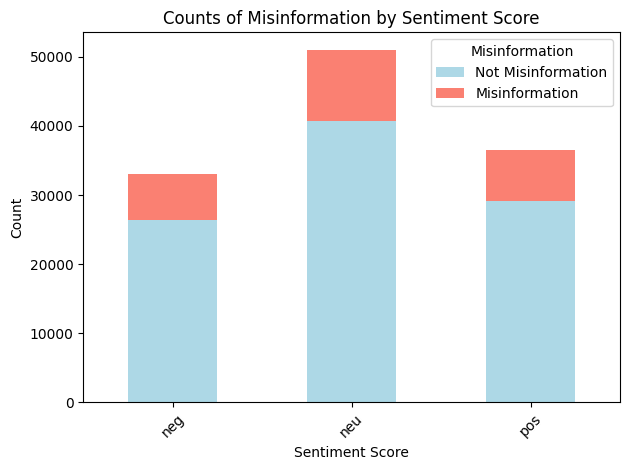

In [ ]:
misinformation_counts = df.groupby(["sentiment", "misinformation"]).size().unstack(fill_value=0)

# Plot the counts of misinformation for each sentiment score category
plt.figure(figsize=(10, 6))
misinformation_counts.plot(kind="bar", stacked=True, color=["lightblue", "salmon"])
plt.title("Counts of Misinformation by Sentiment Score")
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.legend(title="Misinformation", labels=["Not Misinformation", "Misinformation"])
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode sentiment and misinformation columns
label_encoder = LabelEncoder()
df["sentiment_encoded"] = label_encoder.fit_transform(df["sentiment"])
df["misinformation_encoded"] = label_encoder.fit_transform(df["misinformation"])

# Calculate correlation coefficient
correlation = df[["sentiment_encoded", "misinformation_encoded"]].corr().iloc[0, 1]

print("Correlation between sentiment and misinformation:", correlation)


Correlation between sentiment and misinformation: -8.910387983164769e-05


In [ ]:
df.dropna(subset=["user_mentions","original_author"], inplace=True)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

#  Create a directed graph to track the spread path
spread_graph = nx.DiGraph()

# Identify misinformation tweets based on fact scores
threshold = 0  # Adjust as needed
misinformation_tweets = df[df["fact_score"] < threshold]

# Trace spread path for each misinformation tweet
for _, tweet in misinformation_tweets.iterrows():
    actual_user = tweet["original_author"]
    mentioned_users = tweet["user_mentions"].split(",")

    # Add edges to the spread graph
    for mentioned_user in mentioned_users:
        spread_graph.add_edge(actual_user, mentioned_user)

        # Add misinformation attribute to the mentioned user
        if mentioned_user not in spread_graph.nodes:
            spread_graph.add_node(mentioned_user, misinformation=1)
        else:
            spread_graph.nodes[mentioned_user]["misinformation"] = 1


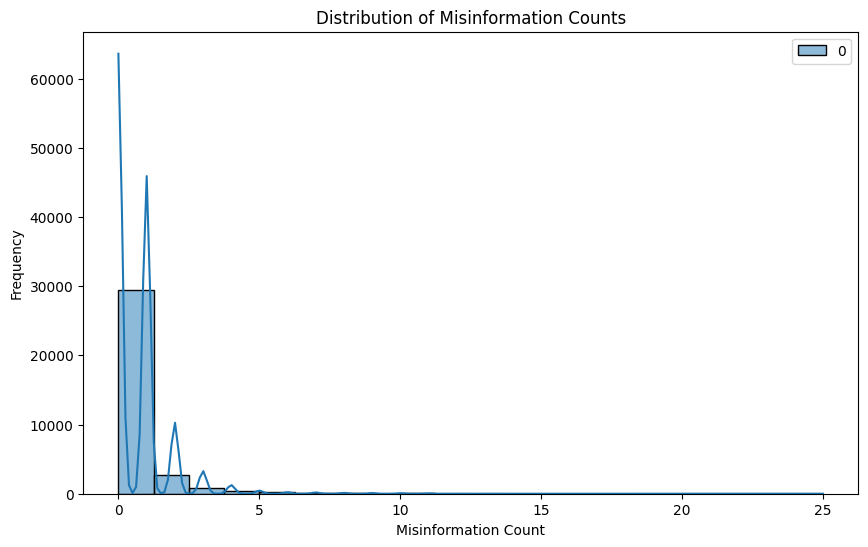

In [ ]:
misinformation_count = {}
for node in spread_graph.nodes():
    misinformation_count[node] = sum([1 for neighbor in spread_graph.neighbors(node) if spread_graph.nodes[neighbor]['misinformation'] == 1])

# Plot the distribution of misinformation counts
plt.figure(figsize=(10, 6))
sns.histplot(misinformation_count.values(), bins=20, kde=True)
plt.title('Distribution of Misinformation Counts')
plt.xlabel('Misinformation Count')
plt.ylabel('Frequency')
plt.show()

In [ ]:
misinformation_matrix = pd.DataFrame(index=spread_graph.nodes(), columns=spread_graph.nodes(), dtype=int)

for node in spread_graph.nodes():
    for neighbor in spread_graph.neighbors(node):
        misinformation_matrix.loc[node, neighbor] = spread_graph.nodes[neighbor]['misinformation']

# Plot the misinformation propagation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(misinformation_matrix, cmap='Blues', cbar=True)
plt.title('Misinformation Propagation Matrix')
plt.xlabel('Recipient')
plt.ylabel('Sender')
plt.show()